### Predict device failures
This is a program to predict failure of devices used in telemetry. The data was downloaded from here: http://aws-proserve-data-science.s3.amazonaws.com/device_failure.csv
<br>
I downloaded the data and saved in: /Users/valentin/GoogleDrive/Data/aws/device_failure.csv

##### Goal:
You are tasked with building a predictive model using machine learning to predict the
probability of a device failure. When building this model, be sure to minimize false positives and
false negatives. The column you are trying to predict is called failure with binary value 0 for
non-failure and 1 for failure.


#### Plan for development
1. Read the data
2. EDA of the data
    * Calculate the distribution of total fail/not fail cases
    * Distribution of fail/not-fail cases by year
    * Distribution of fail/not-fail cases by month
    * Are there any devices that have higher failure rates than others
    * When a device fails, does it disappear from the data, or 
3. Determine which features are categorical, and if needed create dummies
4. Derive new features
    * Use decision trees to decide how to split by categories of attributes
    * Should I do PCA? (likely no..)
4. Sampling of the data (70/30)
    * Create random samples from the data - 70% for training and 30% for validation
    * If the cases are too few compared to the non-cases, I may need to oversample the cases, or simply undersample the non-cases
7. Variables reduction
    * Use p-values
    * LASSO
    * Random forest's variable importance
    * Stepwise logistic regression
    * Compare the suggested features from each method
8. Decide on a methodology for the model estimation
    * Random forest
    * SVM
    * Survival analysis
9. Validate the results
10. Calculate c-statistic and ROC
11. Create a confusion matrix - reduce false positives and false negatives
12. Does the methodology we use allow us to understand what drives the outcome? If it doesn't, do we need another methodology that can help with that?


In [130]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Read in the data and print out the header
device_data = pd.read_csv("/Users/valentin/GoogleDrive/Data/aws/device_failure.csv")
device_data.head(10)

device_data.attribute8

# Check if the number of rows is as expected
len(device_data)

124494

In [131]:
# Calculate the distribution of total fail/not fail cases
pct_fail_cases = sum(device_data["failure"]) / len(device_data["failure"]) * 100
print("It appears that the data is very imbalanced. The percent of fail cases is very low compared to the non-fail cases.")
print("Only %s of the cases are device failures" % pct_fail_cases)

It appears that the data is very imbalanced. The percent of fail cases is very low compared to the non-fail cases.
Only 0.0851446656064 of the cases are device failures


We need to dig a little deeper into the distributions of failure/non-failure and understand the following:
1. Distribution of failure/non-failure by year
2. Distribution of failure/non-failure by month
3. Distribution of failure/non-failure by device - are there specific devices that tend to fail more than others?

In [132]:
# Distribution of failure/non-failure by year
device_data["year"] = pd.to_datetime(device_data["date"]).dt.year
device_data["month"] = pd.to_datetime(device_data["date"]).dt.month

print(pd.crosstab(device_data["year"],
                  columns = "count"))
pd.crosstab(device_data["month"],
            columns = "count") / len(device_data.month)

col_0   count
year         
2015   124494


col_0,count
month,
1,0.201070
2,0.156634
3,0.159309
4,0.096487
5,0.091008
6,0.084092
7,0.084590
8,0.067039
9,0.035905


It is evident that the data is only for 2015 and we have information for most of the months of 2015, except for December. However, note that 50% of the observations are from the period January - March.
<p>
Next, we'll look at the distribution of failure/non-failure by month

In [133]:
# Distribution of failure/non-failure by month
failure_month = pd.crosstab(index = device_data["failure"],
                            columns = device_data["month"],
                            margins = True)

failure_month.index = ["non_failures", "failures", "month_total"]
failure_month

month,1,2,3,4,5,6,7,8,9,10,11,All
non_failures,25008,19486,19824,12003,11309,10463,10515,8342,4470,2937,31,124388
failures,24,14,9,9,21,6,16,4,0,3,0,106
month_total,25032,19500,19833,12012,11330,10469,10531,8346,4470,2940,31,124494


In [134]:
failure_month_pct = failure_month / failure_month.ix["month_total"]
failure_month_pct

month,1,2,3,4,5,6,7,8,9,10,11,All
non_failures,0.999041,0.999282,0.999546,0.999251,0.998147,0.999427,0.998481,0.999521,1.0,0.99898,1.0,0.999149
failures,0.000959,0.000718,0.000454,0.000749,0.001853,0.000573,0.001519,0.000479,0.0,0.00102,0.0,0.000851
month_total,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.0,1.000000


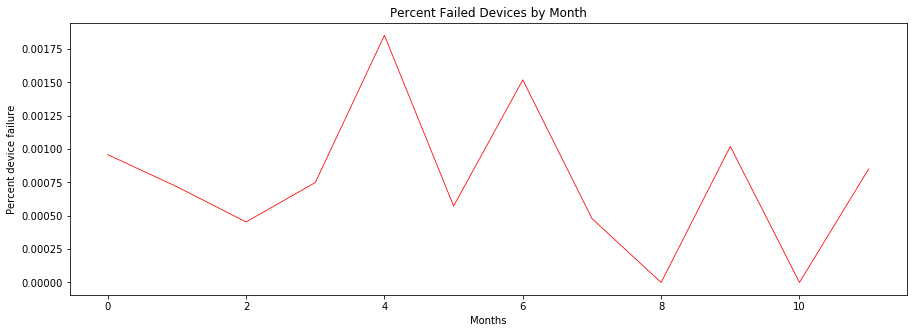

In [135]:
# Plot the % failures/non-failures by month
plt.figure(figsize = (15, 5))
plt.plot(list(failure_month_pct.ix["failures"]), linewidth = 0.8, color = "#ff0000")
plt.xlabel("Months")
plt.ylabel("Percent device failure")
plt.title("Percent Failed Devices by Month")

In [137]:
# Plot the % failures/non-failures by day


plt.figure(figsize = (15, 5))
plt.plot(list(failure_day_pct.ix["failures"]), linewidth = 0.8, color = "#ff0000")
plt.xlabel("Months")
plt.ylabel("Percent device failure")
plt.title("Percent Failed Devices by Month")

SyntaxError: invalid syntax (<ipython-input-137-7ef16af0fdd2>, line 3)

In [ ]:
list(device_data.columns.values)